In [1]:
# !pip install akshare --upgrade
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def fetch_etf_data(symbol, start_date, end_date):
    """
    获取ETF历史数据
    :param symbol: ETF代码
    :param start_date: 开始日期，格式"YYYYMMDD"
    :param end_date: 结束日期，格式"YYYYMMDD"
    :return: 包含历史数据的DataFrame
    """
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date, end_date=end_date, 
                                adjust="hfq")
        # 重命名列以保持一致性
        cols = {'日期':'date', '开盘':'open', '最高':'high', 
               '最低':'low', '收盘':'close', '成交量':'volume'}
        df.rename(columns=cols, inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['open', 'high', 'low', 'close', 'volume']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

In [3]:
def calculate_metrics(price_series):
    """
    计算回测指标
    :param price_series: 价格序列
    :return: 年化收益率, 夏普比率, 最大回撤
    """
    returns = price_series.pct_change().dropna()
    
    # 年化收益率
    annual_return = (1 + returns.mean()) ** 252 - 1
    
    # 年化波动率
    annual_volatility = returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率为3%)
    sharpe_ratio = (annual_return - 0.03) / annual_volatility
    
    # 最大回撤
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return annual_return, sharpe_ratio, max_drawdown

In [4]:
end_date = datetime.now().strftime("%Y%m%d")
start_date = (datetime.now() - timedelta(days=5*365)).strftime("%Y%m%d")

etf_codes = {
    '159919': '沪深300ETF',
    '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

etf_data = {}
for code, name in etf_codes.items():
    print(f"正在获取{name}({code})数据...")
    etf_data[code] = fetch_etf_data(code, start_date, end_date)

正在获取沪深300ETF(159919)数据...


  0%|          | 0/11 [00:00<?, ?it/s]

正在获取创业板50ETF(159949)数据...
正在获取红利ETF(510880)数据...
正在获取上证5年期国债ETF(511010)数据...


/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 21019 (\N{CJK UNIFIED IDEOGRAPH-521B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 26495 (\N{CJK UNIFIED IDEOGRAPH-677F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13913/1119937182.py:31: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAP

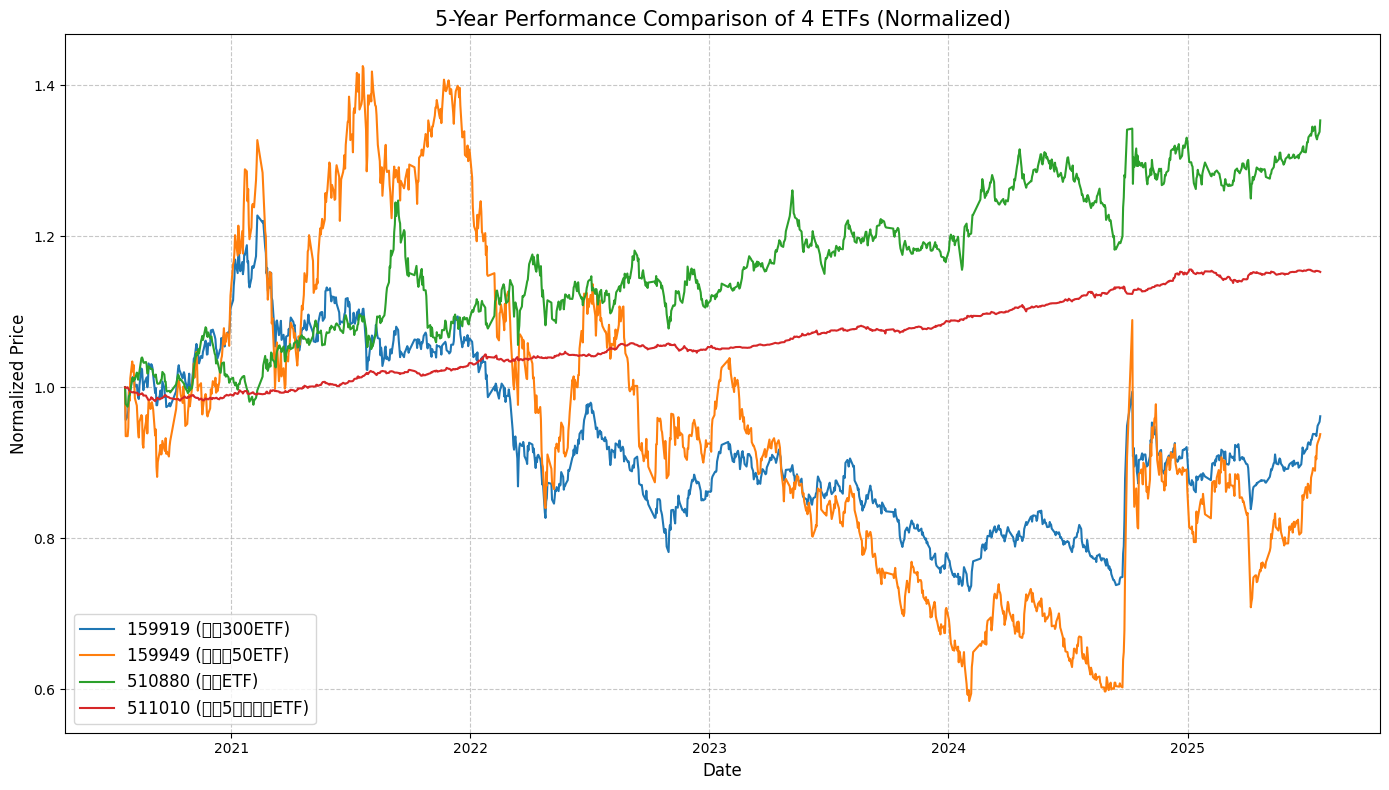


Backtesting Results Summary:
ETF Code   ETF Name Annual Return Sharpe Ratio Max Drawdown  Latest NAV
  159919   沪深300ETF         0.71%        -0.13      -40.51%       1.978
  159949   创业板50ETF         3.95%         0.03      -58.99%       1.043
  510880      红利ETF         7.25%         0.36      -15.34%       4.733
  511010 上证5年期国债ETF         3.02%         0.01       -1.84%     142.675


In [7]:
plt.figure(figsize=(14, 8))
results = []

for code, df in etf_data.items():
    if df is not None and not df.empty:
        # Calculate metrics
        annual_return, sharpe_ratio, max_drawdown = calculate_metrics(df['close'])
        
        # Normalize price series for comparison (set first day price as 1)
        normalized_price = df['close'] / df['close'].iloc[0]
        
        # Plot curve
        plt.plot(normalized_price, label=f"{code} ({etf_codes[code]})")
        
        # Store results
        results.append({
            'ETF Code': code,
            'ETF Name': etf_codes[code],
            'Annual Return': f"{annual_return*100:.2f}%",
            'Sharpe Ratio': f"{sharpe_ratio:.2f}",
            'Max Drawdown': f"{max_drawdown*100:.2f}%",
            'Latest NAV': df['close'].iloc[-1]
        })

# Format plot
plt.title('5-Year Performance Comparison of 4 ETFs (Normalized)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print("\nBacktesting Results Summary:")
print(results_df.to_string(index=False))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取沪深300ETF(159919)数据...


获取创业板50ETF(159949)数据...
获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...
策略绩效指标(5年回测):
总收益率: 3.52%
年化收益率: 0.48%
年化波动率: 12.86%
夏普比率: -0.20
最大回撤: -26.52%
Alpha: -1.48%
Beta: 0.41

分年度收益率:
2021: 3.44%
2022: -18.87%
2023: 5.35%
2024: 17.88%
2025: -0.68%


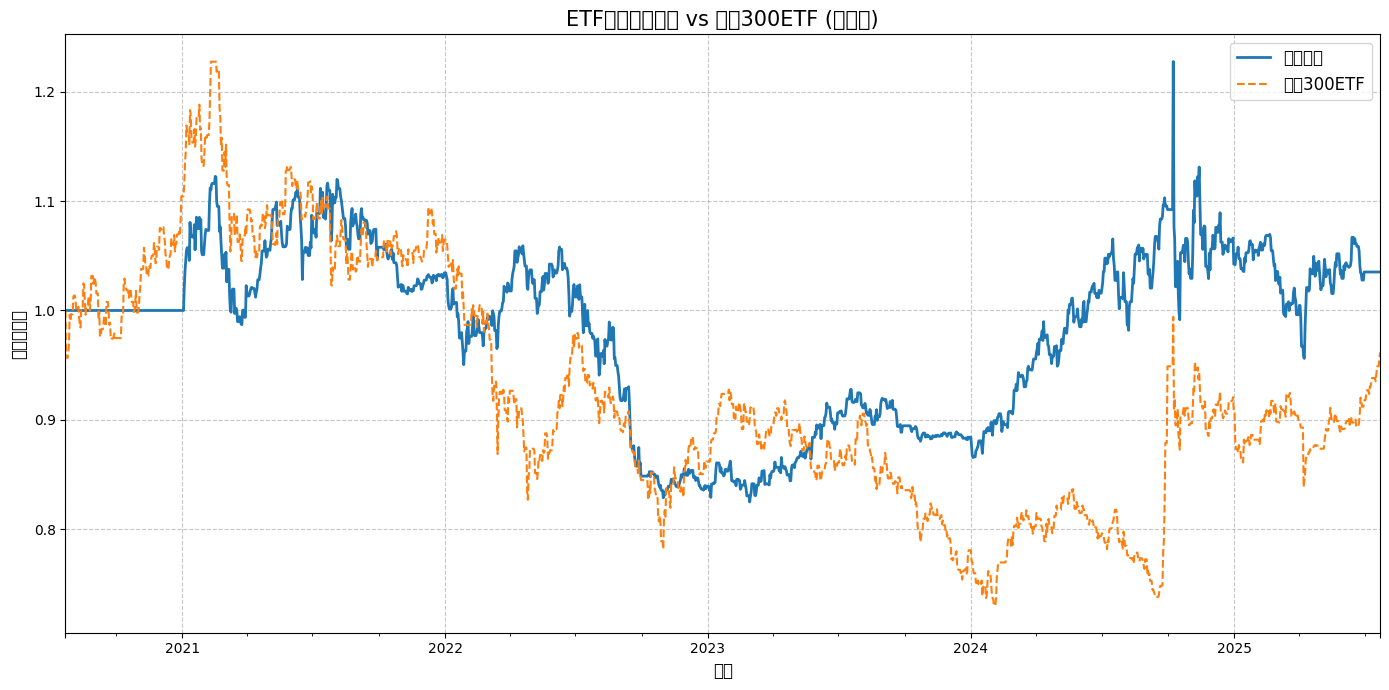

In [10]:
# 安装必要库
# !pip install yfinance akshare --upgrade

# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF'
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

china_etfs = {
    '159919': '沪深300ETF',
    '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

# 修改后的季度轮动策略回测函数
def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=10000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金
    :return: 回测结果DataFrame
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的2只ETF
        if len(returns) >= 2:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:2]
            selected_tickers = [x[0] for x in selected]
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value

# 执行回测
portfolio_value = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Alpha(相对于沪深300)
    benchmark = all_etfs['159919']['close'] / all_etfs['159919']['close'].iloc[0]
    benchmark_returns = benchmark.pct_change().dropna()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 计算Beta
    covariance = np.cov(aligned_returns, aligned_benchmark)[0, 1]
    benchmark_variance = np.var(aligned_benchmark)
    beta = covariance / benchmark_variance
    
    # 计算Alpha
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    alpha = annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns)

# ================== 结果展示部分 ==================

print("策略绩效指标(5年回测):")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha: {metrics['Alpha']*100:.2f}%")
print(f"Beta: {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / portfolio_value.iloc[0]).plot(label='策略净值', linewidth=2)

# 绘制沪深300作为比较
benchmark = all_etfs['159919']['close'] / all_etfs['159919']['close'].iloc[0]
benchmark.plot(label='沪深300ETF', linestyle='--')

plt.title('ETF季度轮动策略 vs 沪深300ETF (标准化)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('标准化净值', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SHY数据...
获取标普500数据...
获取创业板50ETF(159949)数据...


获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...
策略绩效指标(5年回测):
总收益率: 12.38%
年化收益率: 1.62%
年化波动率: 11.66%
夏普比率: -0.12
最大回撤: -22.08%
Alpha(相对于标普500): -2.91%
Beta(相对于标普500): 0.20

分年度收益率:
2021: 3.44%
2022: -13.96%
2023: 6.09%
2024: 20.37%
2025: -1.12%


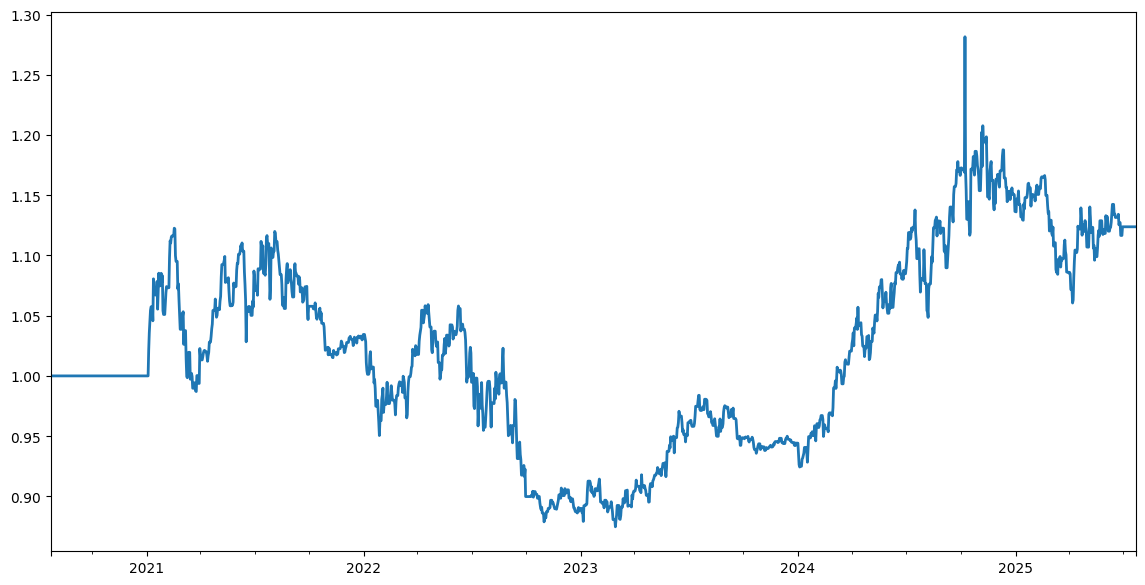

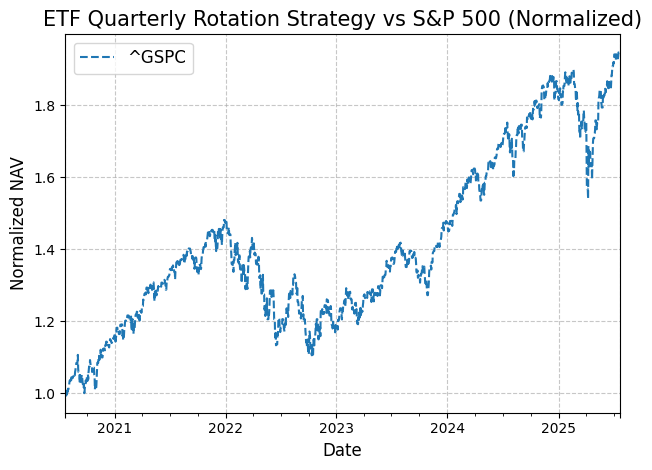

In [16]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SHY': '1-3年期国债ETF'  # 新增SHY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 修改后的中国ETF列表，去掉了沪深300ETF
china_etfs = {
    '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=10000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金
    :return: 回测结果DataFrame
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的2只ETF
        if len(returns) >= 2:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:2]
            selected_tickers = [x[0] for x in selected]
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value

# 执行回测
portfolio_value = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

# 修改后的绩效计算部分
def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 修正协方差计算 - 确保输入是1D数组
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# 结果展示部分
print("策略绩效指标(5年回测):")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")  # 现在metrics['Alpha']是标量值
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / portfolio_value.iloc[0]).plot(label='Strategy NAV', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='S&P 500', linestyle='--')

plt.title('ETF Quarterly Rotation Strategy vs S&P 500 (Normalized)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized NAV', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SHY数据...
获取标普500数据...
获取创业板50ETF(159949)数据...


获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...

季度选择记录:
2020-09-30: 选择基金  (现金)
2020-12-31: 选择基金 SOYB, 159949, QQQ (大豆ETF, 创业板50ETF, 纳斯达克ETF)
2021-03-31: 选择基金 SOYB, 510880, QQQ (大豆ETF, 红利ETF, 纳斯达克ETF)
2021-06-30: 选择基金 159949, QQQ, SOYB (创业板50ETF, 纳斯达克ETF, 大豆ETF)
2021-09-30: 选择基金 510880, 511010, QQQ (红利ETF, 上证5年期国债ETF, 纳斯达克ETF)
2021-12-31: 选择基金 QQQ, GLD, SOYB (纳斯达克ETF, 黄金ETF, 大豆ETF)
2022-03-31: 选择基金 SOYB, 510880, GLD (大豆ETF, 红利ETF, 黄金ETF)
2022-06-30: 选择基金 159949, SOYB, 511010 (创业板50ETF, 大豆ETF, 上证5年期国债ETF)
2022-09-30: 选择基金 511010, 510880, SHY (上证5年期国债ETF, 红利ETF, 1-3年期国债ETF)
2022-12-31: 选择基金 GLD, SOYB, 159949 (黄金ETF, 大豆ETF, 创业板50ETF)
2023-03-31: 选择基金 QQQ, GLD, 510880 (纳斯达克ETF, 黄金ETF, 红利ETF)
2023-06-30: 选择基金 QQQ, 511010, 510880 (纳斯达克ETF, 上证5年期国债ETF, 红利ETF)
2023-09-30: 选择基金 510880, SHY, 511010 (红利ETF, 1-3年期国债ETF, 上证5年期国债ETF)
2023-12-31: 选择基金 QQQ, GLD, SHY (纳斯达克ETF, 黄金ETF, 1-3年期国债ETF)
2024-03-31: 选择基金 QQQ, GLD, 510880 (纳斯达克ETF, 黄金ETF, 红利ETF)
2024-06-30: 选择基金 QQQ, GLD, 510880 (纳斯达克ETF, 黄金ETF, 

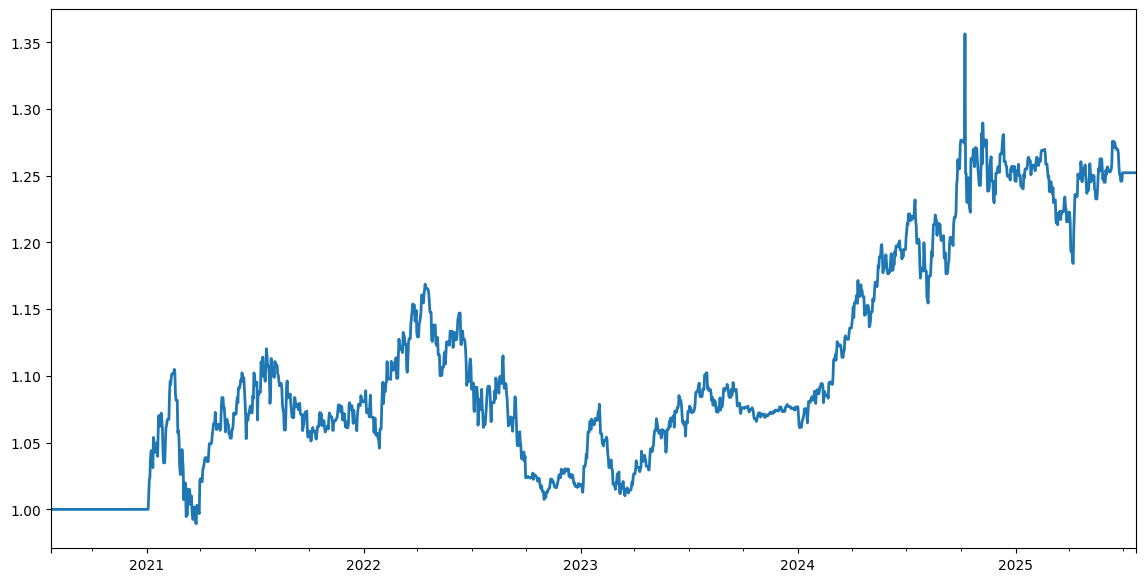

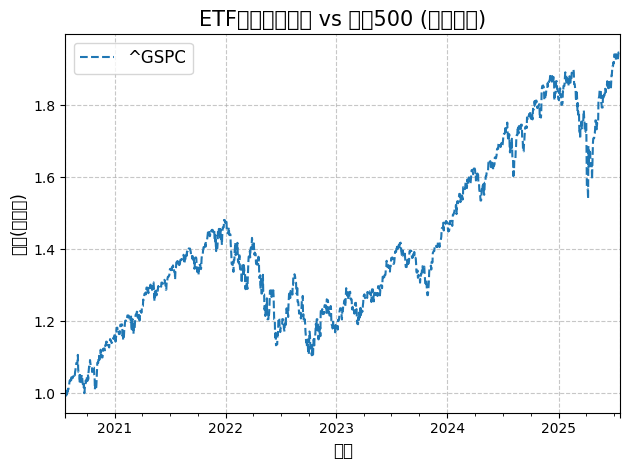

In [18]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SHY': '1-3年期国债ETF'  # 新增SHY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 修改后的中国ETF列表，去掉了沪深300ETF
china_etfs = {
    '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(修改为10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的3只ETF
        if len(returns) >= 3:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:3]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配33.33%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 修正协方差计算 - 确保输入是1D数组
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]  # 修正后的变量名
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度轮动策略 vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SHY数据...
获取SPY数据...
获取标普500指数数据...
获取创业板50ETF(159949)数据...


获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...

季度选择记录:
2020-09-30: 选择基金  (现金)
2020-12-31: 选择基金 SOYB, 159949, QQQ, SPY (大豆ETF, 创业板50ETF, 纳斯达克ETF, 标普500ETF)
2021-03-31: 选择基金 SOYB, SPY, 510880, QQQ (大豆ETF, 标普500ETF, 红利ETF, 纳斯达克ETF)
2021-06-30: 选择基金 159949, QQQ, SOYB, SPY (创业板50ETF, 纳斯达克ETF, 大豆ETF, 标普500ETF)
2021-09-30: 选择基金 510880, 511010, QQQ, SPY (红利ETF, 上证5年期国债ETF, 纳斯达克ETF, 标普500ETF)
2021-12-31: 选择基金 QQQ, SPY, GLD, SOYB (纳斯达克ETF, 标普500ETF, 黄金ETF, 大豆ETF)
2022-03-31: 选择基金 SOYB, 510880, GLD, 511010 (大豆ETF, 红利ETF, 黄金ETF, 上证5年期国债ETF)
2022-06-30: 选择基金 159949, SOYB, 511010, SHY (创业板50ETF, 大豆ETF, 上证5年期国债ETF, 1-3年期国债ETF)
2022-09-30: 选择基金 511010, 510880, SHY, SOYB (上证5年期国债ETF, 红利ETF, 1-3年期国债ETF, 大豆ETF)
2022-12-31: 选择基金 GLD, SOYB, SPY, 159949 (黄金ETF, 大豆ETF, 标普500ETF, 创业板50ETF)
2023-03-31: 选择基金 QQQ, GLD, SPY, 510880 (纳斯达克ETF, 黄金ETF, 标普500ETF, 红利ETF)
2023-06-30: 选择基金 QQQ, SPY, 511010, 510880 (纳斯达克ETF, 标普500ETF, 上证5年期国债ETF, 红利ETF)
2023-09-30: 选择基金 510880, SHY, 511010, SOYB (红利ETF, 1-3年期国债ETF, 上证5年期

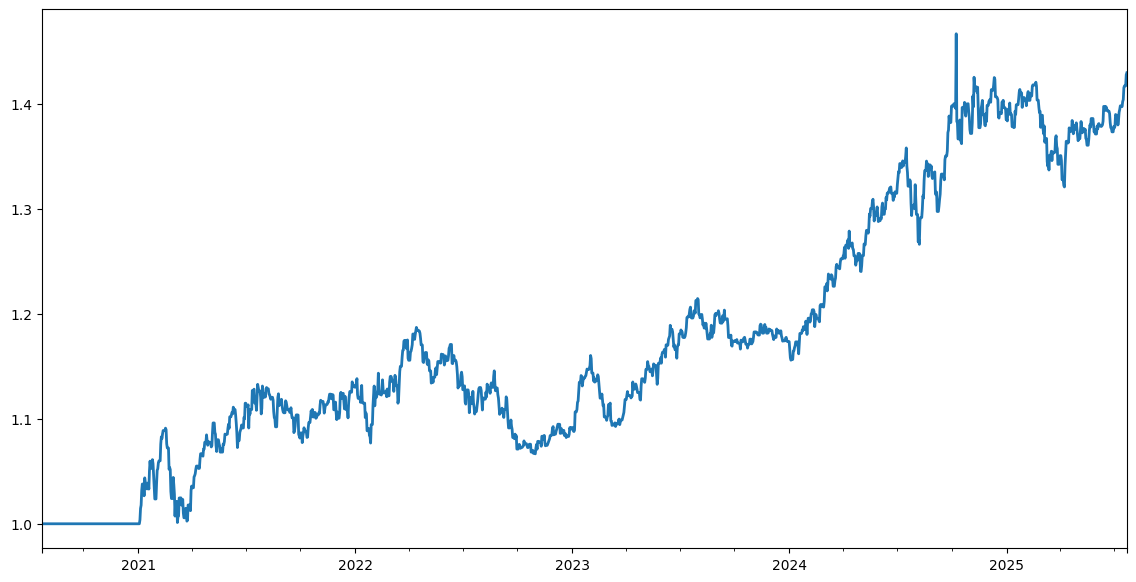

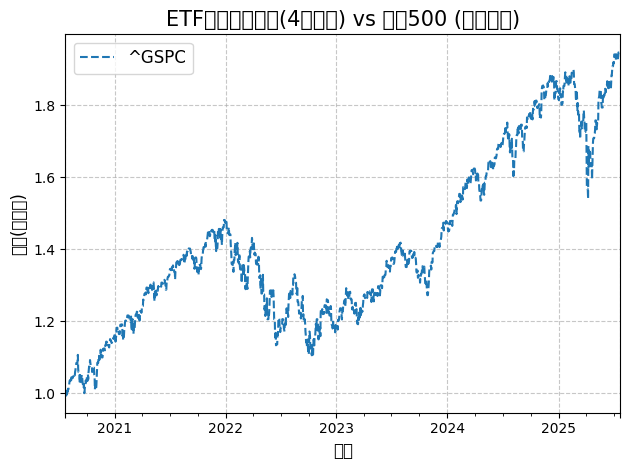

In [20]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SHY': '1-3年期国债ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列
    # quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的4只ETF
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 修正协方差计算 - 确保输入是1D数组
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度轮动策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取SHY数据...
获取SPY数据...
获取标普500指数数据...
获取chuangye-50ETF(159949)数据...


获取red-ETF(510880)数据...
获取cnbond-ETF(511010)数据...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

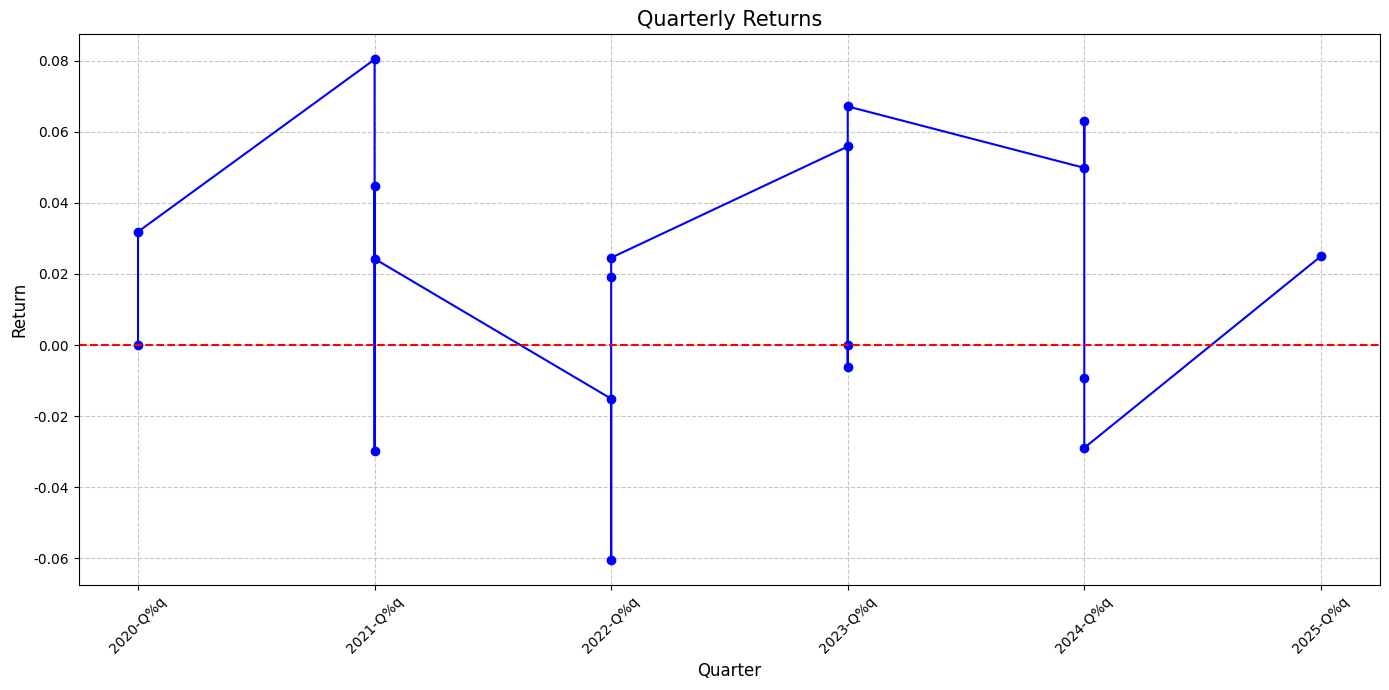

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

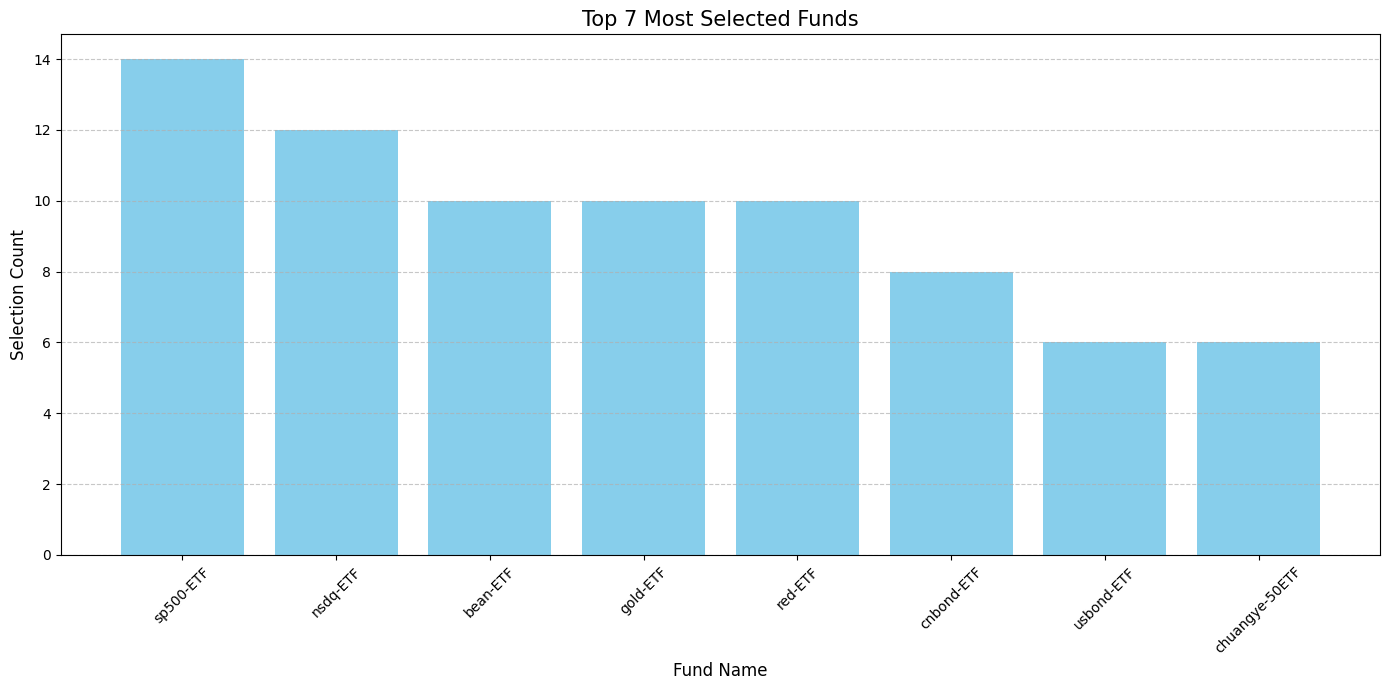

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

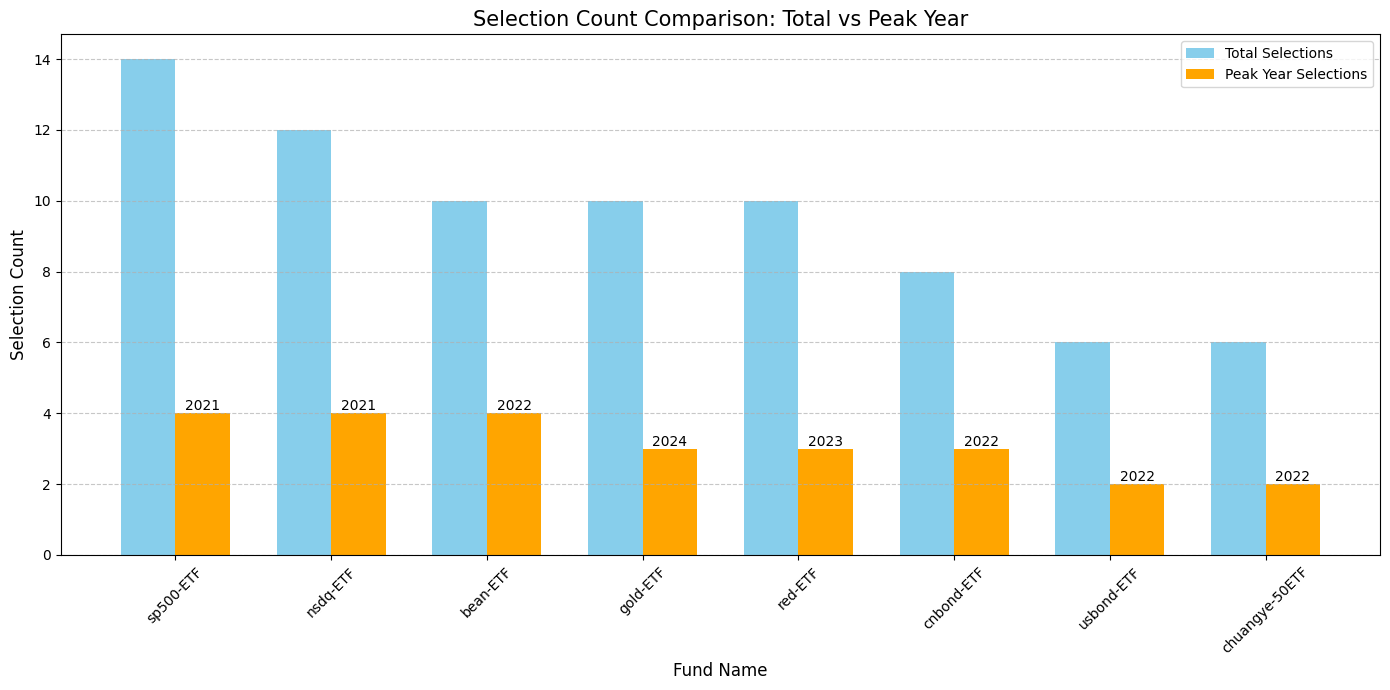

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


季度选择记录:
2020-09-30: 选择基金  (现金)
2020-12-31: 选择基金 SOYB, 159949, QQQ, SPY (bean-ETF, chuangye-50ETF, nsdq-ETF, sp500-ETF)
2021-03-31: 选择基金 SOYB, SPY, 510880, QQQ (bean-ETF, sp500-ETF, red-ETF, nsdq-ETF)
2021-06-30: 选择基金 159949, QQQ, SOYB, SPY (chuangye-50ETF, nsdq-ETF, bean-ETF, sp500-ETF)
2021-09-30: 选择基金 510880, 511010, QQQ, SPY (red-ETF, cnbond-ETF, nsdq-ETF, sp500-ETF)
2021-12-31: 选择基金 QQQ, SPY, GLD, SOYB (nsdq-ETF, sp500-ETF, gold-ETF, bean-ETF)
2022-03-31: 选择基金 SOYB, 510880, GLD, 511010 (bean-ETF, red-ETF, gold-ETF, cnbond-ETF)
2022-06-30: 选择基金 159949, SOYB, 511010, SHY (chuangye-50ETF, bean-ETF, cnbond-ETF, usbond-ETF)
2022-09-30: 选择基金 511010, 510880, SHY, SOYB (cnbond-ETF, red-ETF, usbond-ETF, bean-ETF)
2022-12-31: 选择基金 GLD, SOYB, SPY, 159949 (gold-ETF, bean-ETF, sp500-ETF, chuangye-50ETF)
2023-03-31: 选择基金 QQQ, GLD, SPY, 510880 (nsdq-ETF, gold-ETF, sp500-ETF, red-ETF)
2023-06-30: 选择基金 QQQ, SPY, 511010, 510880 (nsdq-ETF, sp500-ETF, cnbond-ETF, red-ETF)
2023-09-30: 选择基金 510880, SHY

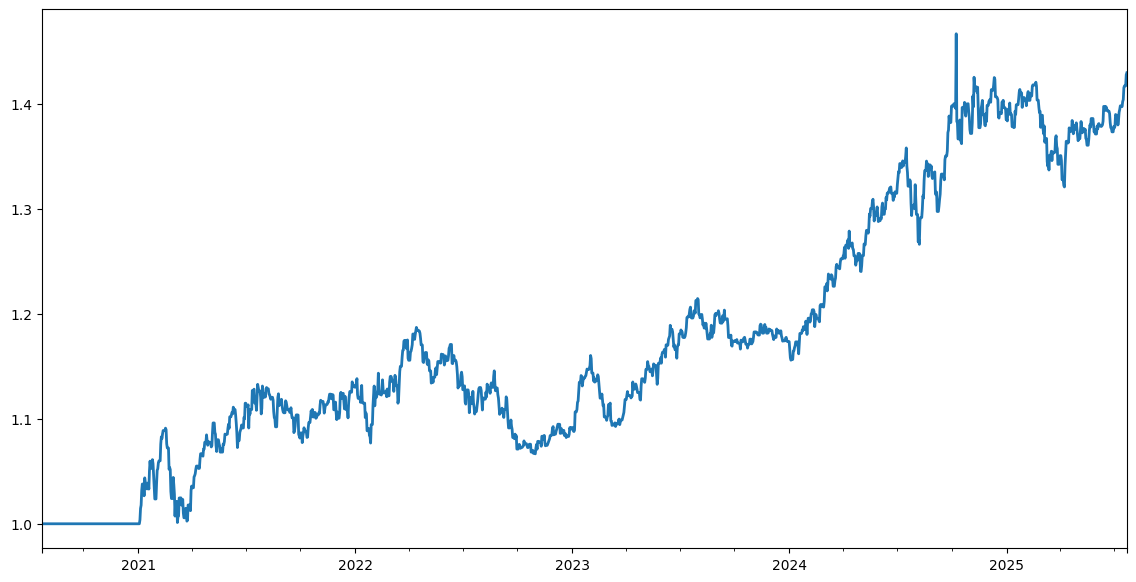

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

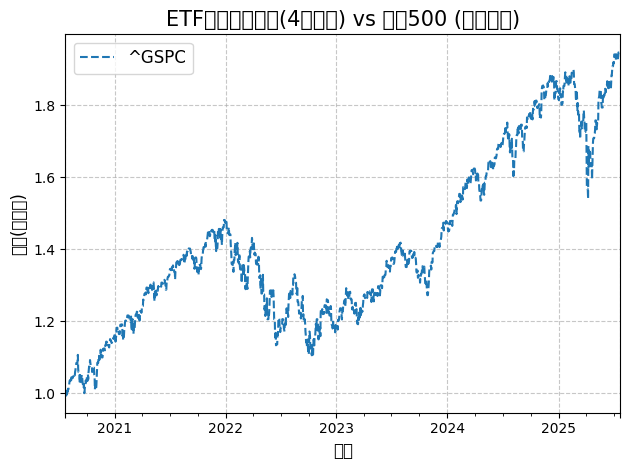

In [27]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': 'nsdq-ETF',
    'SOYB': 'bean-ETF',
    'GLD': 'gold-ETF',
    'SHY': 'usbond-ETF',
    'SPY': 'sp500-ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    '159949': 'chuangye-50ETF',
    '510880': 'red-ETF',
    '511010': 'cnbond-ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列
    # quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的4只ETF
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# ================== 新增分析部分 ==================

# 1. 准备季度收益数据
quarterly_returns = []
quarter_dates = []
for i in range(len(quarterly_selections)-1):
    start_date = quarterly_selections[i][0]
    end_date = quarterly_selections[i+1][0]
    start_value = portfolio_value[start_date]
    end_value = portfolio_value[end_date]
    q_return = (end_value - start_value) / start_value
    quarterly_returns.append(q_return)
    quarter_dates.append(start_date.strftime('%Y-Q%q'))

# 2. 统计基金选择次数
all_funds = list(intl_etfs.values()) + list(china_etfs.values())
selection_counts = {fund: 0 for fund in all_funds}
yearly_selections = {}

for selection in quarterly_selections:
    date, tickers, names = selection
    year = date.year
    if year not in yearly_selections:
        yearly_selections[year] = {fund: 0 for fund in all_funds}
    for name in names:
        if name in selection_counts:
            selection_counts[name] += 1
            yearly_selections[year][name] += 1

# 找出被选择最多的7只基金
top_funds = sorted(selection_counts.items(), key=lambda x: x[1], reverse=True)[:8]
top_fund_names = [x[0] for x in top_funds]
top_fund_counts = [x[1] for x in top_funds]

# 找出这些基金被选择最多的年份
top_fund_years = {}
for fund in top_fund_names:
    max_year = max(yearly_selections.items(), key=lambda x: x[1][fund])[0]
    top_fund_years[fund] = (yearly_selections[max_year][fund], max_year)

# ================== 可视化部分 ==================

# 1. 季度收益曲线图
plt.figure(figsize=(14, 7))
plt.plot(quarter_dates, quarterly_returns, marker='o', linestyle='-', color='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Quarterly Returns', fontsize=15)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. 基金选择次数柱状图
plt.figure(figsize=(14, 7))
plt.bar(top_fund_names, top_fund_counts, color='skyblue')
plt.title('Top 7 Most Selected Funds', fontsize=15)
plt.xlabel('Fund Name', fontsize=12)
plt.ylabel('Selection Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. 最多选择年度的双柱状图
plt.figure(figsize=(14, 7))
x = np.arange(len(top_fund_names))
width = 0.35

# 总选择次数
bars1 = plt.bar(x - width/2, top_fund_counts, width, label='Total Selections', color='skyblue')

# 最多选择年度的选择次数
max_year_counts = [top_fund_years[fund][0] for fund in top_fund_names]
max_years = [str(top_fund_years[fund][1]) for fund in top_fund_names]
bars2 = plt.bar(x + width/2, max_year_counts, width, label='Peak Year Selections', color='orange')

plt.title('Selection Count Comparison: Total vs Peak Year', fontsize=15)
plt.xlabel('Fund Name', fontsize=12)
plt.ylabel('Selection Count', fontsize=12)
plt.xticks(x, top_fund_names, rotation=45)
plt.legend()

# 在柱子顶部添加最多选择年度标签
for i, (bar, year) in enumerate(zip(bars2, max_years)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             year,
             ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 修正协方差计算 - 确保输入是1D数组
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度轮动策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
import matplotlib as mpl
print(mpl.get_cachedir())

/home/luany/.cache/matplotlib


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SPY数据...
获取标普500指数数据...
获取红利ETF(510880)数据...


获取上证5年期国债ETF(511010)数据...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


季度选择记录:
2020-09-30: 选择基金  (现金)
2020-12-31: 选择基金 SOYB, QQQ, SPY, 510880 (大豆ETF, 纳斯达克ETF, 标普500ETF, 红利ETF)
2021-03-31: 选择基金 SOYB, SPY, 510880, QQQ (大豆ETF, 标普500ETF, 红利ETF, 纳斯达克ETF)
2021-06-30: 选择基金 QQQ, SOYB, SPY, GLD (纳斯达克ETF, 大豆ETF, 标普500ETF, 黄金ETF)
2021-09-30: 选择基金 510880, 511010, QQQ, SPY (红利ETF, 上证5年期国债ETF, 纳斯达克ETF, 标普500ETF)
2021-12-31: 选择基金 QQQ, SPY, GLD, SOYB (纳斯达克ETF, 标普500ETF, 黄金ETF, 大豆ETF)
2022-03-31: 选择基金 SOYB, 510880, GLD, 511010 (大豆ETF, 红利ETF, 黄金ETF, 上证5年期国债ETF)
2022-06-30: 选择基金 SOYB, 511010, 510880, GLD (大豆ETF, 上证5年期国债ETF, 红利ETF, 黄金ETF)
2022-09-30: 选择基金 511010, 510880, SOYB, QQQ (上证5年期国债ETF, 红利ETF, 大豆ETF, 纳斯达克ETF)
2022-12-31: 选择基金 GLD, SOYB, SPY, 511010 (黄金ETF, 大豆ETF, 标普500ETF, 上证5年期国债ETF)
2023-03-31: 选择基金 QQQ, GLD, SPY, 510880 (纳斯达克ETF, 黄金ETF, 标普500ETF, 红利ETF)
2023-06-30: 选择基金 QQQ, SPY, 511010, 510880 (纳斯达克ETF, 标普500ETF, 上证5年期国债ETF, 红利ETF)
2023-09-30: 选择基金 510880, 511010, SOYB, QQQ (红利ETF, 上证5年期国债ETF, 大豆ETF, 纳斯达克ETF)
2023-12-31: 选择基金 QQQ, SPY, GLD, 511010 (纳斯达克ETF, 标普500

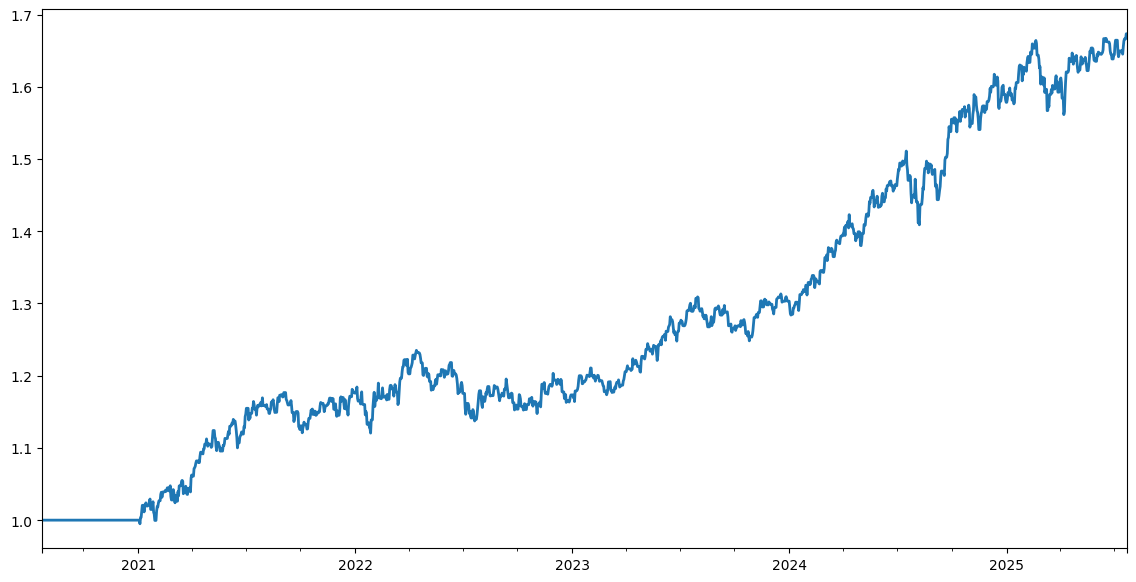

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

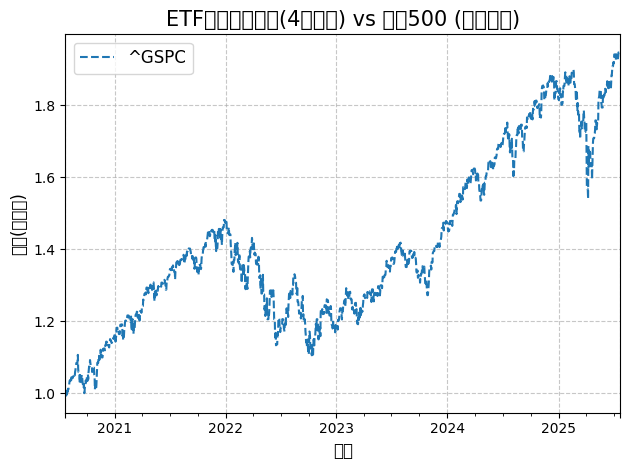

In [65]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159949': '创业板50ETF',
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列
    # quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的4只ETF
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度轮动策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SPY数据...
获取^VIX数据...
获取标普500指数数据...
获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


增强版策略季度选择记录:
2020-09-30: 选择基金  (现金)
2020-12-31: 选择基金 SOYB, QQQ, SPY, 510880 (大豆ETF, 纳斯达克ETF, 标普500ETF, 红利ETF)
2021-03-31: 选择基金 SOYB, SPY, 510880, QQQ (大豆ETF, 标普500ETF, 红利ETF, 纳斯达克ETF)
2021-06-30: 选择基金 QQQ, SOYB, SPY (纳斯达克ETF, 大豆ETF, 标普500ETF)
2021-09-30: 选择基金 510880, 511010 (红利ETF, 上证5年期国债ETF)
2021-12-31: 选择基金 QQQ, SPY, GLD, SOYB (纳斯达克ETF, 标普500ETF, 黄金ETF, 大豆ETF)
2022-03-31: 选择基金 SOYB, 510880, GLD (大豆ETF, 红利ETF, 黄金ETF)
2022-06-30: 选择基金 511010, GLD, 511010, 510880 (上证5年期国债ETF, 黄金ETF, 上证5年期国债ETF, 红利ETF)
2022-09-30: 选择基金 511010, GLD, 511010, 510880 (上证5年期国债ETF, 黄金ETF, 上证5年期国债ETF, 红利ETF)
2022-12-31: 选择基金 GLD, SOYB (黄金ETF, 大豆ETF)
2023-03-31: 选择基金 QQQ, GLD, SPY, 510880 (纳斯达克ETF, 黄金ETF, 标普500ETF, 红利ETF)
2023-06-30: 选择基金 QQQ, SPY, 511010 (纳斯达克ETF, 标普500ETF, 上证5年期国债ETF)
2023-09-30: 选择基金 511010 (上证5年期国债ETF)
2023-12-31: 选择基金 QQQ, SPY, GLD, 511010 (纳斯达克ETF, 标普500ETF, 黄金ETF, 上证5年期国债ETF)
2024-03-31: 选择基金 SPY, QQQ, GLD, 510880 (标普500ETF, 纳斯达克ETF, 黄金ETF, 红利ETF)
2024-06-30: 选择基金 QQQ, SPY, 510880 (纳斯达克

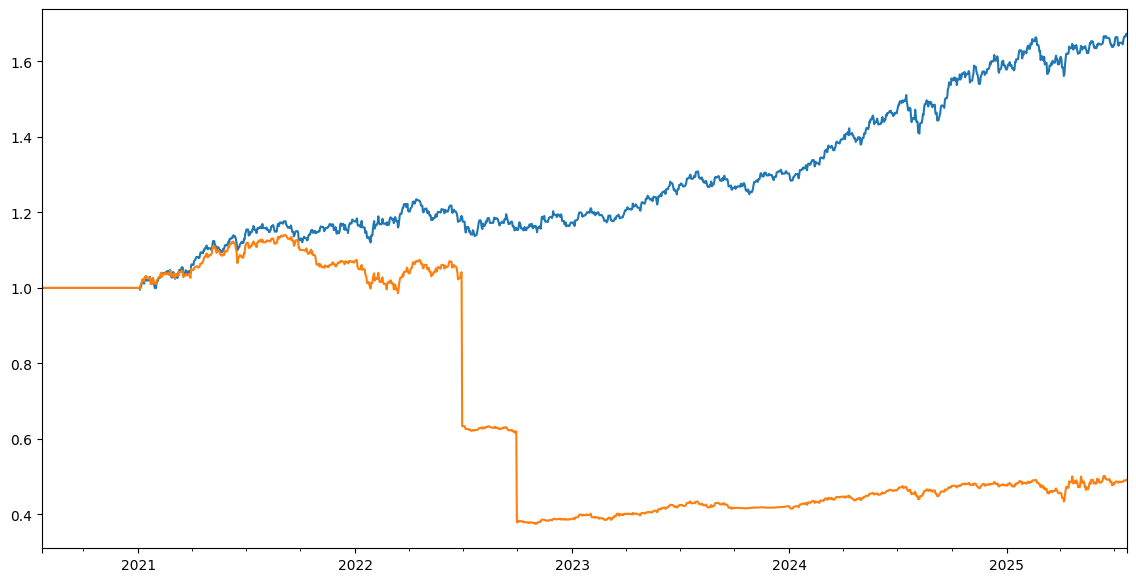

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

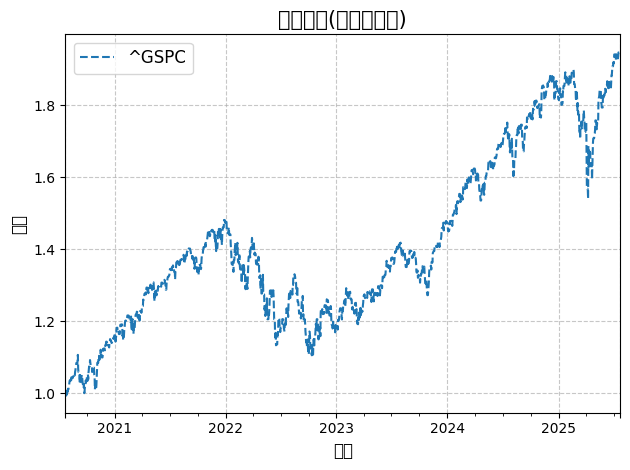

In [37]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SPY': '标普500ETF',
    '^VIX': '恐慌指数'  # 新增VIX用于防御策略
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    if ticker != '^VIX':  # 排除VIX，它只用于参考
        all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略优化部分 ==================

def dynamic_allocation(returns):
    """动态权重分配 - 表现越好分配越多"""
    ranked = sorted(returns.items(), key=lambda x: x[1], reverse=True)
    weights = [0.35, 0.3, 0.25, 0.1]  # 按排名分配权重
    return {ticker: w for (ticker, _), w in zip(ranked[:4], weights)}

def momentum_filter(tickers, etf_data, current_date, lookback=63):
    """动量过滤 - 只选择过去3个月正收益的ETF"""
    valid = []
    for t in tickers:
        start = current_date - pd.Timedelta(days=lookback)
        if start in etf_data[t].index and current_date in etf_data[t].index:
            start_price = etf_data[t].loc[start, 'close']
            end_price = etf_data[t].loc[current_date, 'close']
            if isinstance(start_price, pd.Series):
                start_price = start_price.iloc[0]
            if isinstance(end_price, pd.Series):
                end_price = end_price.iloc[0]
            ret = end_price / start_price - 1
            if ret > 0:  # 只选择正收益的
                valid.append(t)
    return valid[:4]  # 仍保持最多4只

def defensive_override(selected, vix_data, current_date, threshold=25):
    """防御模式 - 当市场波动大时增加防御资产"""
    if current_date in vix_data.index:
        current_vix = vix_data.loc[current_date, 'close']
        if isinstance(current_vix, pd.Series):
            current_vix = current_vix.iloc[0]
        if current_vix > threshold:
            defensive_assets = ['GLD', '511010']  # 黄金和国债
            # 保留1只原优选，加入2只防御资产
            return [selected[0]] + defensive_assets[:2] + selected[1:2]
    return selected

# ================== 策略回测部分 ==================

def enhanced_quarterly_rotation(etf_data, start_date, end_date, initial_capital=100000):
    """
    增强版季度轮动策略
    """
    # 获取VIX数据用于防御策略
    vix_data = intl_data['^VIX'].reindex(all_dates).fillna(method='ffill')
    
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}
    current_cash = initial_capital
    quarterly_selections = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 1. 原始季度轮动选基
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        if len(returns) >= 4:
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            
            # 2. 动量过滤
            selected_tickers = momentum_filter(selected_tickers, etf_data, quarter_start)
            
            # 3. 防御调整
            selected_tickers = defensive_override(selected_tickers, vix_data, quarter_start)
            
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 4. 动态权重分配
        if selected_tickers:
            current_returns = {t: returns[t] for t in selected_tickers if t in returns}
            if len(current_returns) >= 2:  # 至少有2只有历史收益数据
                weights = dynamic_allocation(current_returns)
                # 确保权重总和为1
                total_weight = sum(weights.values())
                normalized_weights = {k: v/total_weight for k, v in weights.items()}
            else:
                normalized_weights = {t: 1/len(selected_tickers) for t in selected_tickers}
            
            for ticker in selected_tickers:
                allocation = current_cash * normalized_weights.get(ticker, 1/len(selected_tickers))
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections

# 执行增强版回测
enhanced_value, enhanced_selections = enhanced_quarterly_rotation(all_etfs, start_date, end_date)

# ================== 绩效计算与展示 ==================

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 修正协方差计算 - 确保输入是1D数组
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ... [保持原有的绩效计算函数不变] ...

# 计算绩效指标
enhanced_metrics = calculate_performance_metrics(enhanced_value, enhanced_value.pct_change().dropna(), sp500['close'].pct_change().dropna())

# 打印结果
print("\n增强版策略季度选择记录:")
for quarter in enhanced_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n增强版策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {enhanced_value.iloc[-1]:,.2f}元")
print(f"总收益率: {enhanced_metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {enhanced_metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {enhanced_metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {enhanced_metrics['夏普比率']:.2f}")
print(f"最大回撤: {enhanced_metrics['最大回撤']*100:.2f}%")

# 绘制对比曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='原始策略', linewidth=1.5)
(enhanced_value / 100000).plot(label='增强策略', linewidth=1.5)
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')
plt.title('策略对比(标准化净值)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分 ==================
# （与之前相同，保持不变）
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SPY': '标普500ETF',
    '^VIX': '恐慌指数'
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

china_etfs = {
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

all_etfs = {}
for ticker, df in intl_data.items():
    if ticker != '^VIX':
        all_etfs[ticker] = df
for code, df in china_data.items():
    all_etfs[code] = df

all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 原始策略实现 ==================
def original_quarterly_rotation(etf_data, start_date, end_date, initial_capital=100000):
    """原始季度轮动策略（固定权重）"""
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}
    current_cash = initial_capital
    quarterly_selections = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去季度收益率
        returns = {}
        for ticker, df in etf_data.items():
            prev_start = quarter_start - pd.offsets.QuarterEnd()
            if prev_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择前4名
        if len(returns) >= 4:
            valid_returns = {k: v for k, v in returns.items() 
                           if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(t, china_etfs.get(t, t)) for t in selected_tickers]
        else:
            selected_tickers = []
            selected_names = ["现金"]
        
        quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        
        # 调仓执行
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓（固定25%权重）
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算每日净值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    return portfolio_value.ffill(), quarterly_selections

# ================== 增强策略实现 ==================
def enhanced_quarterly_rotation(etf_data, start_date, end_date, initial_capital=100000):
    """增强版季度轮动策略（修复Series问题）"""
    """优化后的增强策略"""
    """修复iloc错误的增强策略"""
    vix_data = intl_data['^VIX'].reindex(all_dates).fillna(method='ffill')
    
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}
    current_cash = initial_capital
    quarterly_selections = []
    quarterly_weights = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 1. 安全计算收益率
        returns = {}
        for ticker, df in etf_data.items():
            prev_start = quarter_start - pd.offsets.QuarterEnd()
            if prev_start in df.index and quarter_start in df.index:
                # 安全获取价格
                start_price = df.loc[prev_start, 'close']
                start_price = start_price.iloc[0] if hasattr(start_price, 'iloc') else float(start_price)
                
                end_price = df.loc[quarter_start, 'close']
                end_price = end_price.iloc[0] if hasattr(end_price, 'iloc') else float(end_price)
                
                returns[ticker] = (end_price - start_price) / start_price
        
        # 2. 动量过滤（同样修复价格获取）
        if len(returns) >= 1:
            valid_returns = {k: v for k, v in returns.items() 
                           if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)
            selected_tickers = [x[0] for x in selected][:4]
            
            momentum_tickers = []
            for t in selected_tickers:
                lookback_start = quarter_start - pd.Timedelta(days=63)
                if lookback_start in etf_data[t].index:
                    # 安全获取动量计算价格
                    start_price = etf_data[t].loc[lookback_start, 'close']
                    start_price = start_price.iloc[0] if hasattr(start_price, 'iloc') else float(start_price)
                    
                    end_price = etf_data[t].loc[quarter_start, 'close']
                    end_price = end_price.iloc[0] if hasattr(end_price, 'iloc') else float(end_price)
                    
                    ret = (end_price / start_price) - 1
                    momentum_tickers.append((t, ret))
            
            if len(momentum_tickers) > 0:
                has_positive = any(x[1] > 0 for x in momentum_tickers)
                if has_positive:
                    selected_tickers = [x[0] for x in momentum_tickers if x[1] > 0][:4]
                else:
                    selected_tickers = [x[0] for x in sorted(
                        momentum_tickers, key=lambda x: x[1], reverse=True)][:4]
        
        # 3. 防御策略（VIX阈值提高到30）
        if quarter_start in vix_data.index:
            current_vix = vix_data.loc[quarter_start, 'close']
            if isinstance(current_vix, pd.Series):
                current_vix = current_vix.iloc[0]
            if current_vix > 30:  # 阈值提高到30
                defensive = ['GLD', '511010']
                selected_tickers = list(dict.fromkeys(
                    selected_tickers[:2] + [d for d in defensive if d in all_etfs]  # 保留2只原优选
                ))[:4]
        
        selected_names = [intl_etfs.get(t, china_etfs.get(t, t)) for t in selected_tickers]
        quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        
        # 4. 动态权重（更保守分配）
        weights = {}
        if selected_tickers:
            current_returns = {t: returns[t] for t in selected_tickers if t in returns}
            if current_returns:
                ranked = sorted(current_returns.items(), key=lambda x: x[1], reverse=True)
                weight_scheme = {
                    1: [1.0],
                    2: [0.55, 0.45],
                    3: [0.4, 0.35, 0.25],
                    4: [0.3, 0.28, 0.25, 0.17]
                }.get(len(ranked), [1.0/len(selected_tickers)]*len(selected_tickers))
                weights = {t: w for (t, _), w in zip(ranked, weight_scheme)}
            else:
                weights = {t: 1/len(selected_tickers) for t in selected_tickers}
        quarterly_weights.append(weights)
        
        # 调仓执行
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 5. 买入新持仓（带安全保护的动态权重）
        if selected_tickers:
            # 安全保护：确保权重有效
            if not weights or sum(weights.values()) <= 0:
                weights = {t: 1/len(selected_tickers) for t in selected_tickers}
            
            total_weight = sum(weights.values())
            # 二次验证
            if total_weight <= 0:
                weights = {t: 1/len(selected_tickers) for t in selected_tickers}
                total_weight = 1.0
            
            for ticker in selected_tickers:
                allocation = current_cash * weights.get(ticker, 0) / total_weight
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算每日净值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    return portfolio_value.ffill(), quarterly_selections, quarterly_weights

# ================== 执行回测 ==================
original_value, original_selections = original_quarterly_rotation(all_etfs, start_date, end_date)
enhanced_value, enhanced_selections, enhanced_weights = enhanced_quarterly_rotation(all_etfs, start_date, end_date)

# ================== 绩效分析 ==================

def calculate_metrics(value_series, benchmark):
    daily_returns = value_series.pct_change().dropna()
    benchmark_returns = benchmark.pct_change().dropna()
    
    # 确保数据对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    
    # 转换为numpy数组并确保正确形状
    returns_array = np.array(aligned_returns).reshape(-1)
    benchmark_array = np.array(aligned_benchmark).reshape(-1)
    
    # 计算Beta
    if len(returns_array) > 1 and len(benchmark_array) > 1:
        covariance = np.cov(returns_array, benchmark_array)[0, 1]
        benchmark_variance = np.var(benchmark_array)
        beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
    else:
        beta = 0
    
    # 其他指标计算保持不变...
    total_return = value_series.iloc[-1] / value_series.iloc[0] - 1
    annualized_return = (1 + total_return) ** (252/len(daily_returns)) - 1
    volatility = daily_returns.std() * np.sqrt(252)
    sharpe = (annualized_return - 0.03) / volatility
    
    cum_returns = (1 + daily_returns).cumprod()
    peak = cum_returns.expanding().max()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    
    # 计算Alpha
    benchmark_annual_return = (1 + benchmark_returns.mean())**252 - 1
    alpha = annualized_return - (0.03 + beta * (benchmark_annual_return - 0.03))
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Alpha': alpha,
        'Beta': beta
    }

original_metrics = calculate_metrics(original_value, sp500['close'])
enhanced_metrics = calculate_metrics(enhanced_value, sp500['close'])

# ================== 结果展示 ==================
print("原始策略绩效:")
print(f"最终净值: {original_value.iloc[-1]:,.2f}")
print(f"年化收益: {original_metrics['Annualized Return']*100:.2f}%")
print(f"最大回撤: {original_metrics['Max Drawdown']*100:.2f}%")

print("\n增强策略绩效:")
print(f"最终净值: {enhanced_value.iloc[-1]:,.2f}")
print(f"年化收益: {enhanced_metrics['Annualized Return']*100:.2f}%")
print(f"最大回撤: {enhanced_metrics['Max Drawdown']*100:.2f}%")

# 绘制对比图
plt.figure(figsize=(14, 7))
(original_value / original_value.iloc[0]).plot(label='Original')
(enhanced_value / enhanced_value.iloc[0]).plot(label='Enhanced')
(sp500['close'] / sp500['close'].iloc[0]).plot(label='S&P 500', ls='--')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

# 输出最近调仓详情
last_idx = -1
print(f"\n最近调仓日期: {enhanced_selections[last_idx][0].strftime('%Y-%m-%d')}")
print("基金分配:")
for ticker, name in zip(enhanced_selections[last_idx][1], enhanced_selections[last_idx][2]):
    weight = enhanced_weights[last_idx].get(ticker, 0)*100
    print(f"- {ticker} ({name}): {weight:.1f}%")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SOYB数据...
获取GLD数据...
获取SPY数据...
获取^VIX数据...
获取红利ETF(510880)数据...


获取上证5年期国债ETF(511010)数据...


UnboundLocalError: local variable 'selected_tickers' referenced before assignment

In [45]:
import yfinance as yf

def check_sp500_ma200():
    # 获取数据
    sp500 = yf.Ticker("^GSPC")
    hist = sp500.history(period="2y")  # 2年数据（约504个交易日）
    
    # 计算200日均线
    hist['MA200'] = hist['Close'].rolling(window=200).mean()
    
    # 获取最新数据
    last_close = hist['Close'].iloc[-1]
    last_ma200 = hist['MA200'].iloc[-1]
    
    # 判断
    if last_close > last_ma200:
        return "上方", last_close, last_ma200
    elif last_close < last_ma200:
        return "下方", last_close, last_ma200
    else:
        return "持平", last_close, last_ma200

# 调用函数
position, close, ma200 = check_sp500_ma200()
print(f"标普500当前收盘价: {close:.2f}")
print(f"200日均线: {ma200:.2f}")
print(f"位置: 在200日均线{position}")

标普500当前收盘价: 6305.78
200日均线: 5876.82
位置: 在200日均线上方


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed

开始获取数据...
正在批量下载国际ETF数据...
获取红利ETF(510880)数据...


获取上证5年期国债ETF(511010)数据...

开始回测...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


季度调仓记录:
2020-09-30: 现金 (现金)
2020-12-31: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2021-03-31: SPY, SOYB (标普500ETF, 大豆ETF)
2021-06-30: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2021-09-30: 510880, SOYB (红利ETF, 大豆ETF)
2021-12-31: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2022-03-31: 510880, SOYB (红利ETF, 大豆ETF)
2022-06-30: 511010, 510880, SOYB (上证5年期国债ETF, 红利ETF, 大豆ETF)
2022-09-30: 511010, 510880, SOYB (上证5年期国债ETF, 红利ETF, 大豆ETF)
2022-12-31: GLD, SPY, SOYB (黄金ETF, 标普500ETF, 大豆ETF)
2023-03-31: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2023-06-30: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2023-09-30: 510880, SOYB (红利ETF, 大豆ETF)
2023-12-31: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2024-03-31: SPY, SOYB (标普500ETF, 大豆ETF)
2024-06-30: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2024-09-30: SPY, SOYB (标普500ETF, 大豆ETF)
2024-12-31: QQQ, SOYB (纳斯达克ETF, 大豆ETF)
2025-03-31: GLD, 510880, SOYB (黄金ETF, 红利ETF, 大豆ETF)
2025-06-30: QQQ, SOYB (纳斯达克ETF, 大豆ETF)

策略绩效:
初始资金: 100,000元
最终资金: 123,892.26元
总收益率: 23.89%
年化收益率: 3.00%
年化波动率: 9.77%
夏普比率: 0.00
最大回撤: -17.53%
Alpha: -2.11%
Beta: 0.27

分年度收益率:
2021: 11.42%
2022:

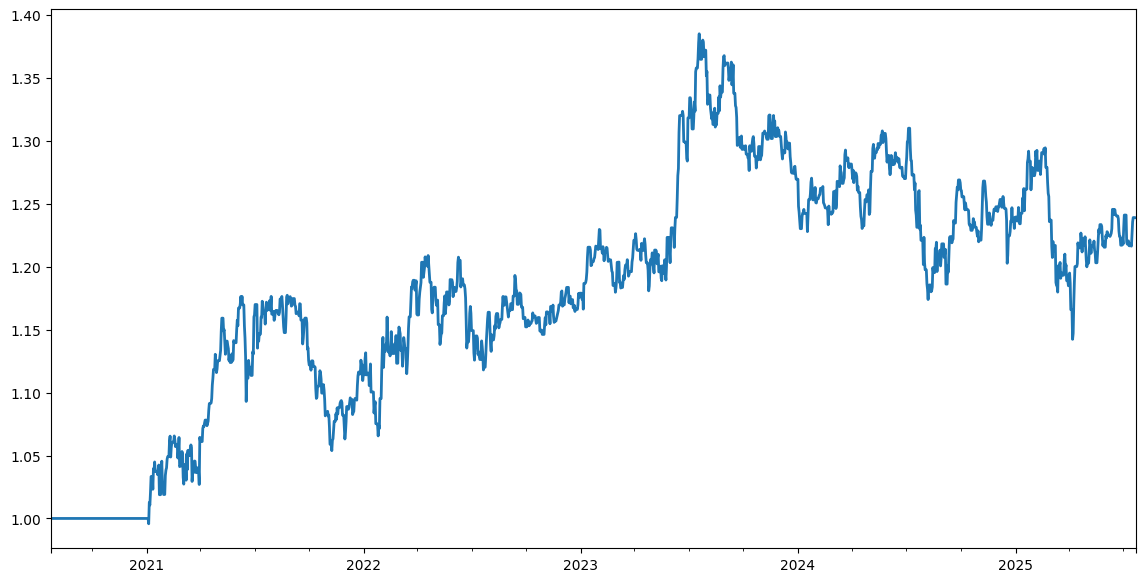

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

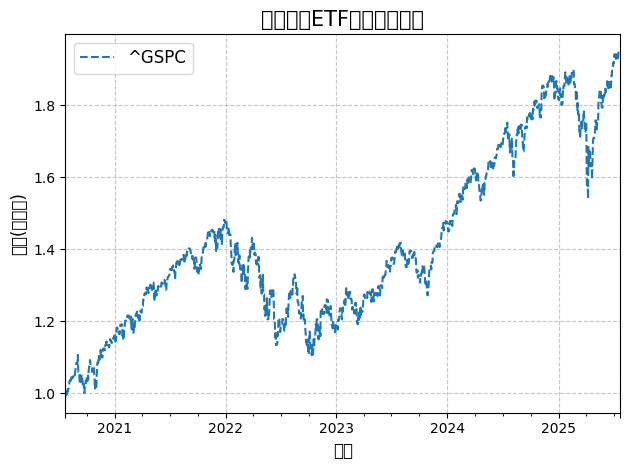

In [60]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=5*365)

# ================== 数据获取部分（优化版） ==================

# 先一次性获取所有yfinance数据
def fetch_yfinance_data(tickers, start_date, end_date):
    """一次性获取所有yfinance数据"""
    print("正在批量下载国际ETF数据...")
    data = yf.download(list(tickers.keys()), start=start_date, end=end_date, group_by='ticker')
    result = {}
    for ticker in tickers:
        if ticker in data:
            result[ticker] = data[ticker]['Close'].rename('close').to_frame()
    return result

# 国际ETF列表
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    'SOYB': '大豆ETF',
    'GLD': '黄金ETF',
    'SPY': '标普500ETF'
}

# 中国ETF列表
china_etfs = {
    '510880': '红利ETF',
    '511010': '上证5年期国债ETF'
}

# 获取数据
print("开始获取数据...")
intl_data = fetch_yfinance_data(intl_etfs, start_date, end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据
def fetch_china_etf_data(symbol, name):
    """获取单个中国ETF数据"""
    try:
        print(f"获取{name}({symbol})数据...")
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date')[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

china_data = {}
for code, name in china_etfs.items():
    df = fetch_china_etf_data(code, name)
    if df is not None:
        china_data[code] = df

# 合并所有数据
all_etfs = {**intl_data, **china_data}
all_dates = pd.date_range(start_date, end_date)

# 统一索引并填充
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略核心部分 ==================

class SP500TrendAnalyzer:
    """标普500趋势分析器（缓存数据避免重复下载）"""
    def __init__(self):
        self.cache = {}
    
    def get_trend(self, date):
        """获取指定日期的趋势状态"""
        year_month = (date.year, date.month)  # 按月缓存
        
        if year_month not in self.cache:
            # 下载当月数据（包含足够长的回溯期）
            lookback_start = date - timedelta(days=300)
            data = yf.download("^GSPC", start=lookback_start, end=date, progress=False)[['Close']].rename(columns={'Close': 'close'})

            ma200 = data.rolling(200).mean()
            self.cache[year_month] = (data, ma200)
        
        data, ma200 = self.cache[year_month]
        
        if len(data) < 200:
            return None
        
        # 确保获取标量值
        last_close = data['close'].iloc[-1]
        last_ma200 = data['close'].rolling(200).mean().iloc[-1]
        
        # 明确转换为float
        last_close = float(last_close)
        last_ma200 = float(last_ma200)
        
        return 'above' if last_close > last_ma200 else 'below'

trend_analyzer = SP500TrendAnalyzer()

# 资产分类配置
asset_classes = {
    '权益类': ['QQQ', 'SPY', '510880'],
    '避险类': ['GLD', '511010'],
    '商品类': ['SOYB']
}

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """优化后的季度轮动策略回测"""
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}
    current_cash = initial_capital
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 获取市场趋势
        trend = trend_analyzer.get_trend(quarter_start)
        
        # 计算各类别过去季度收益率
        class_returns = {}
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        
        for class_name, tickers in asset_classes.items():
            valid_tickers = [t for t in tickers if t in etf_data]
            if not valid_tickers:
                continue
                
            returns = []
            for ticker in valid_tickers:
                try:
                    start_price = etf_data[ticker].loc[prev_quarter_start, 'close']
                    end_price = etf_data[ticker].loc[quarter_start, 'close']
                    returns.append((end_price - start_price) / start_price)
                except:
                    continue
            
            if returns:
                class_returns[class_name] = np.mean(returns)
        
        # 根据趋势选择资产类别
        if trend == 'above':
            # 牛市配置: 2只权益类 + 1只商品类
            selected_classes = ['权益类', '商品类']
        else:
            # 熊市配置: 1只避险类 + 1只权益类 + 1只商品类
            selected_classes = ['避险类', '权益类', '商品类']
        
        # 从每个类别中选择表现最好的ETF
        selected_tickers = []
        for class_name in selected_classes:
            if class_name not in class_returns:
                continue
                
            class_tickers = asset_classes[class_name]
            valid_tickers = [t for t in class_tickers if t in etf_data]
            if not valid_tickers:
                continue
                
            # 计算这些ETF的季度收益率
            ticker_returns = {}
            for ticker in valid_tickers:
                try:
                    start_price = etf_data[ticker].loc[prev_quarter_start, 'close']
                    end_price = etf_data[ticker].loc[quarter_start, 'close']
                    ticker_returns[ticker] = (end_price - start_price) / start_price
                except:
                    continue
            
            if ticker_returns:
                best_ticker = max(ticker_returns.items(), key=lambda x: x[1])[0]
                selected_tickers.append(best_ticker)
        
        # 确保不超过3只
        selected_tickers = selected_tickers[:3]
        selected_names = [intl_etfs.get(t, china_etfs.get(t, t)) for t in selected_tickers]
        quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        
        # 调仓操作
        rebalance_prices = {}
        for ticker in selected_tickers:
            rebalance_prices[ticker] = etf_data[ticker].loc[quarter_start, 'close']
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            current_cash += shares * etf_data[ticker].loc[quarter_start, 'close']
        current_holdings = {}
        
        # 买入新持仓(每只基金33.33%仓位)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                shares = allocation / rebalance_prices[ticker]
                current_holdings[ticker] = shares
                current_cash -= shares * rebalance_prices[ticker]
        
        # 更新每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date not in portfolio_value.index:
                continue
                
            daily_value = current_cash
            for ticker, shares in current_holdings.items():
                daily_value += shares * etf_data[ticker].loc[date, 'close']
            portfolio_value.loc[date] = daily_value
    
    return portfolio_value.ffill(), quarterly_selections

# ================== 回测执行 ==================

print("\n开始回测...")
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date)
daily_returns = portfolio_value.pct_change().dropna()
sp500_returns = sp500['close'].pct_change().dropna()

# ================== 绩效计算 ==================

def calculate_performance(portfolio_value, daily_returns, benchmark_returns):
    """优化后的绩效计算函数"""
    # 确保输入是一维数据
    def ensure_1d(data):
        if isinstance(data, pd.DataFrame):
            return data.iloc[:, 0] if data.shape[1] == 1 else data.squeeze()
        elif isinstance(data, np.ndarray):
            return data.ravel() if data.ndim > 1 else data
        return data
    
    daily_returns = ensure_1d(daily_returns)
    benchmark_returns = ensure_1d(benchmark_returns)
    
    # 对齐数据
    aligned_data = pd.DataFrame({
        'strategy': pd.Series(daily_returns),
        'benchmark': pd.Series(benchmark_returns)
    }).dropna()
    
    # 基础指标计算
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    annualized_vol = aligned_data['strategy'].std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.03) / annualized_vol
    
    # 最大回撤
    cum_returns = (1 + aligned_data['strategy']).cumprod()
    max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()
    
    # Alpha/Beta计算
    if len(aligned_data) > 1:
        cov_matrix = np.cov(aligned_data['strategy'], aligned_data['benchmark'])
        beta = cov_matrix[0, 1] / aligned_data['benchmark'].var()
        benchmark_annual = (1 + aligned_data['benchmark'].mean())**252 - 1
        alpha = annualized_return - (0.03 + beta * (benchmark_annual - 0.03))
    else:
        beta = np.nan
        alpha = np.nan
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change().dropna()
    yearly_returns.index = yearly_returns.index.year
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_vol,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }




metrics = calculate_performance(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示 ==================

print("\n季度调仓记录:")
for q in quarterly_selections:
    date = q[0].strftime('%Y-%m-%d')
    tickers = ", ".join(q[1]) if q[1] else "现金"
    names = ", ".join(q[2]) if q[2] else "现金"
    print(f"{date}: {tickers} ({names})")

print("\n策略绩效:")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha: {metrics['Alpha']*100:.2f}%")
print(f"Beta: {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制净值曲线
plt.figure(figsize=(14, 7))
(portfolio_value/100000).plot(label='策略净值', linewidth=2)
(sp500['close']/sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')
plt.title('优化后的ETF轮动策略表现', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()